In [1]:
#  Imports
import pandas as pd
import numpy as np
import sqlite3
import pickle  # We'll use this to save our model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("--- Phase 4: Predictive Modeling ---")

--- Phase 4: Predictive Modeling ---


In [2]:
# Cell 2: Load Prepared Data from SQL
db_path = '/workspaces/Engine_Predictive_System/data/turbofan.db'
table_name = 'train_data_FD001'

try:
    conn = sqlite3.connect(db_path)
    # Load the full, cleaned training dataset
    df_full = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    print(f"Data loaded from SQL: {df_full.shape}")
except Exception as e:
    print(f"Error loading data: {e}")

df_full.head()

Data loaded from SQL: (20631, 18)


,unit_number,time_cycle,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [4]:
#  Feature Engineering (The "Secret Sauce")
# We create rolling window features (averages and standard deviations)
# This captures the *trend* and *stability* of sensors over time.

# Define a window size, e.g., 5 cycles
window_size = 5

# List of sensors to engineer (based on our Phase 3 EDA)
# We'll pick the top correlated sensors
sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 
           'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 
           'sensor_20', 'sensor_21']

# Group by engine unit and apply rolling functions
df_grouped = df_full.groupby('unit_number')

# Create new feature columns
for sensor in sensors:
    # Rolling average
    df_full[f'{sensor}_avg'] = df_grouped[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    # Rolling standard deviation
    df_full[f'{sensor}_std'] = df_grouped[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

print("Created rolling features.")

# Note: The rolling functions create NaN values for the first (window_size - 1) rows
# of each engine. We MUST drop these.
df_engineered = df_full.dropna()

print(f"Shape after dropping NaNs: {df_engineered.shape}")
print("\n--- Data with Engineered Features ---")
df_engineered.head()

Created rolling features.
Shape after dropping NaNs: (20231, 42)

--- Data with Engineered Features ---


,unit_number,time_cycle,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,...,sensor_13_avg,sensor_13_std,sensor_15_avg,sensor_15_std,sensor_17_avg,sensor_17_std,sensor_20_avg,sensor_20_std,sensor_21_avg,sensor_21_std
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,...,2388.048,0.025884,8.41334,0.025953,391.8,1.095445,38.958,0.073621,23.39302,0.033498
5,1,6,642.10,1584.47,1398.37,21.61,554.67,2388.02,9049.68,47.16,...,2388.050,0.023452,8.41160,0.025727,391.6,1.140175,38.942,0.051186,23.38260,0.031436
6,1,7,642.48,1592.32,1397.77,21.61,554.34,2388.02,9059.13,47.36,...,2388.042,0.021679,8.40472,0.023476,391.6,1.140175,38.962,0.086718,23.37336,0.021634
7,1,8,642.56,1582.96,1400.97,21.61,553.85,2388.00,9040.80,47.24,...,2388.042,0.021679,8.40268,0.022477,391.8,0.836660,38.966,0.086487,23.36664,0.034405
8,1,9,642.12,1590.98,1394.80,21.61,553.69,2388.05,9046.46,47.29,...,2388.036,0.008944,8.40360,0.020740,391.8,0.836660,39.000,0.077136,23.37318,0.038939


In [5]:
# Prepare Data for Modeling (X and y)

# Define our feature list (X)
# This includes our new engineered features + time_cycle
features = ['time_cycle'] + [f'{s}_avg' for s in sensors] + [f'{s}_std' for s in sensors]

# Define our target (y)
target = 'RUL'

# Create the X and y dataframes
X = df_engineered[features]
y = df_engineered[target]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (20231, 25)
Target (y) shape: (20231,)


In [6]:
# : Train/Test Split (Time-Series Aware)
# *** CRITICAL: We CANNOT shuffle randomly. ***
# We must split by engine unit to prevent data leakage.
# We'll use ~80% of engines for training, ~20% for testing.

# Get all unique engine IDs
all_units = df_engineered['unit_number'].unique()
total_units = len(all_units)

# Manually split the list of engine IDs
split_point = int(total_units * 0.8) # 80/20 split
train_units = all_units[:split_point]
test_units = all_units[split_point:]

# Create the train/test sets based on these unit IDs
X_train = X[df_engineered['unit_number'].isin(train_units)]
y_train = y[df_engineered['unit_number'].isin(train_units)]

X_test = X[df_engineered['unit_number'].isin(test_units)]
y_test = y[df_engineered['unit_number'].isin(test_units)]

print(f"Total Engines: {total_units}")
print(f"Training Engines ({len(train_units)}): {train_units}")
print(f"Testing Engines ({len(test_units)}): {test_units}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Total Engines: 100
Training Engines (80): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
Testing Engines (20): [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100]
X_train shape: (15818, 25), y_train shape: (15818,)
X_test shape: (4413, 25), y_test shape: (4413,)


In [ ]:
#  Train the Model (Random Forest Regressor)

print("\n--- Training Random Forest Model ---")
# Instantiate the model
# n_estimators=100 is a good default. 
# n_jobs=-1 uses all your CPU cores for faster training.
# random_state=42 ensures your results are reproducible.
rf_model = RandomForestRegressor(n_estimators=100, 
                                 random_state=42, 
                                 n_jobs=-1)

# Fit the model
rf_model.fit(X_train, y_train)

print("Model training complete.")


--- Training Random Forest Model ---
Model training complete.



--- Evaluating Model Performance ---
Root Mean Squared Error (RMSE): 48.62
R-squared (R²): 0.60

Interpretation: Our model's RUL predictions are, on average, off by ~48.62 cycles.


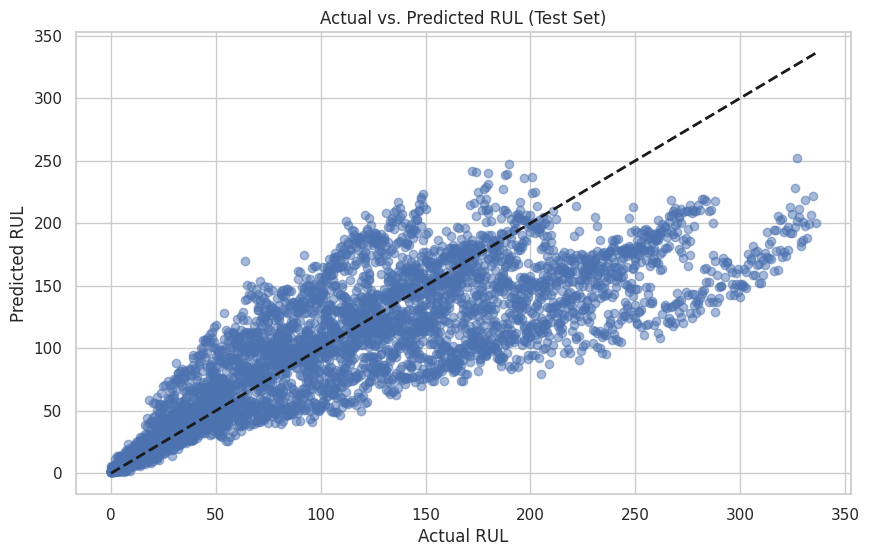

In [ ]:
# Evaluate the Model

print("\n--- Evaluating Model Performance ---")

# Make predictions on the test set (our "unseen" engines)
y_pred = rf_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"\nInterpretation: Our model's RUL predictions are, on average, off by ~{rmse:.2f} cycles.")

# Plot Predictions vs. Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL (Test Set)')
plt.show()


--- Feature Importance ---
          feature  importance
0      time_cycle    0.575458
3    sensor_4_avg    0.117272
6   sensor_11_avg    0.030632
9   sensor_15_avg    0.030284
7   sensor_12_avg    0.019666
1    sensor_2_avg    0.019303
12  sensor_21_avg    0.018363
8   sensor_13_avg    0.016449
5    sensor_8_avg    0.016089
2    sensor_3_avg    0.014988


/tmp/ipykernel_7534/561082378.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


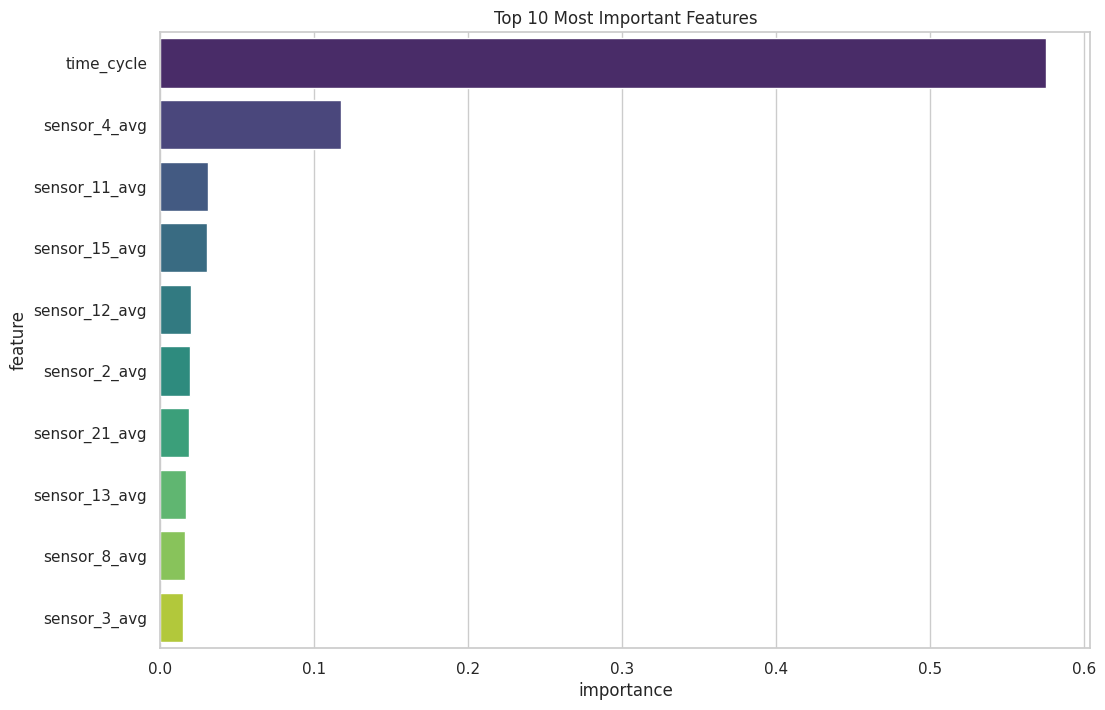

In [ ]:
#  Feature Importance
# Let's see what the model thought was most important.

print("\n--- Feature Importance ---")
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))

# Plot the top 10 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features')
plt.show()

In [10]:
#  *** SAVE THE MODEL AND FEATURES ***

# Create a 'models' folder if it doesn't exist
import os
model_dir = '/workspaces/Engine_Predictive_System/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define file paths
model_path = os.path.join(model_dir, 'rul_model.pkl')
features_path = os.path.join(model_dir, 'model_features.pkl')

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to {model_path}")

# Save the list of features
# (This ensures we always use the exact same features in the dashboard)
with open(features_path, 'wb') as f:
    pickle.dump(features, f)
print(f"Feature list saved to {features_path}")

Model saved to /workspaces/Engine_Predictive_System/models/rul_model.pkl
Feature list saved to /workspaces/Engine_Predictive_System/models/model_features.pkl
